In [5]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = 'C:/Users/aless/OneDrive - Università degli Studi di Catania/tesi/dataset/scaled_dataset.csv'
from sklearn.model_selection import cross_validate, StratifiedGroupKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
cv = StratifiedGroupKFold(n_splits=15, shuffle=True, random_state=46)

In [3]:
df = pd.read_csv(path, index_col=0)
df.head()

,min_hr,max_hr,mean_hr,median_hr,var_hr,std_hr,skew_hr,kurt_hr,min_st,max_st,mean_st,median_st,var_st,std_st,skew_st,kurt_st,target,ID
0,0.447531,0.44192,0.469939,0.464876,0.008988,0.094470,0.531569,0.035987,0.928227,0.944060,0.937919,0.937014,0.002369,0.048639,0.504285,0.051480,0.0,0
1,0.447658,0.44192,0.471027,0.466061,0.008589,0.092343,0.527895,0.037719,0.928227,0.944060,0.937961,0.937014,0.002371,0.048661,0.503165,0.051407,0.0,0
2,0.447722,0.44192,0.472097,0.467611,0.008139,0.089878,0.524656,0.039461,0.928227,0.944667,0.937979,0.937014,0.002392,0.048870,0.504175,0.051732,0.0,0
3,0.448104,0.44192,0.473156,0.469282,0.007640,0.087072,0.522211,0.040991,0.928227,0.944667,0.938063,0.937014,0.002406,0.049017,0.502161,0.051341,0.0,0
4,0.449060,0.44192,0.474201,0.470771,0.007106,0.083957,0.520813,0.042076,0.928227,0.948555,0.938160,0.937014,0.002527,0.050240,0.508913,0.054240,0.0,0


In [4]:
X = df.drop(['ID', 'target'], axis=1, inplace=False)
y = df.target
groups = df.ID

In [7]:
# Create and train the logistic regression model
model = LogisticRegression(C = 1.0, penalty = 'l1', solver = 'saga', random_state=46, class_weight = 'balanced')
model.fit(X,y)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=46,
                   solver='saga')

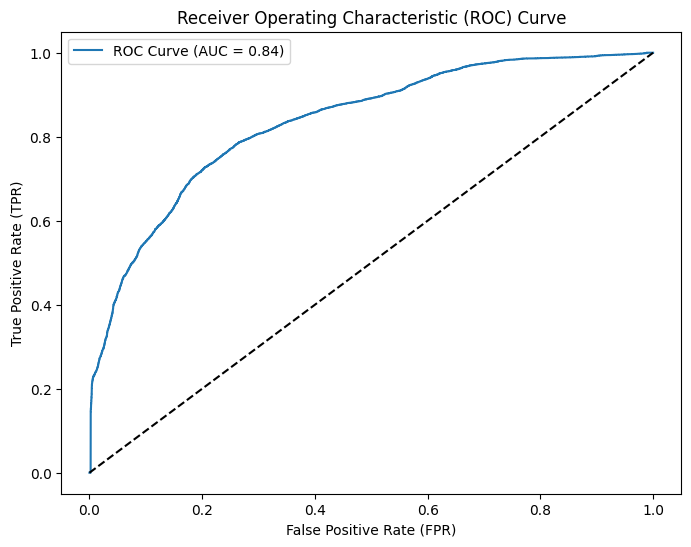

Optimal Threshold: 0.59


In [9]:
# Predict probabilities of the positive class (class 1)
y_pred_prob = cross_val_predict(model, X, y, cv=cv, groups = groups, method='predict_proba')[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Find the threshold for the top-left corner of the ROC curve (maximize TPR while keeping FPR low)
# You can choose other points on the ROC curve depending on your requirements
top_left_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[top_left_idx]

print(f"Optimal Threshold: {round(optimal_threshold, 2)}")

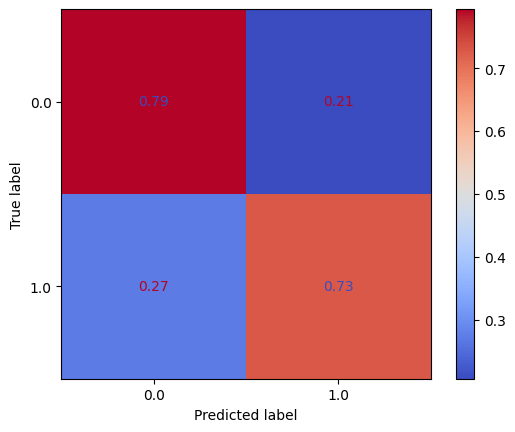

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
optimal_threshold = 0.59
y_prob = cross_val_predict(model, X, y, cv=cv, groups = groups, method='predict_proba')
y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)

# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', cmap='coolwarm')

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81     18780
         1.0       0.68      0.73      0.70     11220

    accuracy                           0.77     30000
   macro avg       0.75      0.76      0.76     30000
weighted avg       0.77      0.77      0.77     30000

